In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [5]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
pickup_dt = df.pickup_datetime.dt
df['Year'] = pickup_dt.year
df['Month'] = pickup_dt.month
df['Day'] = pickup_dt.dayofweek
df['Hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)
df['Distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude) 
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,Year,Month,Day,Hour,Distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Splitting Dataset

In [7]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15135, 6), (3784, 6), (15135,), (3784,))

# Training

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.linear_model import ElasticNet

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count','Year','Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['Month', 'Day', 'Hour']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.0005397956855996446, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8331949117361646, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7118025163555521 0.7084607865223754 0.725420888249005


C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+05, tolerance: 1.405e+02
  model = cd_fast.enet_coordinate_descent(


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [27]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count','Year','Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['Month', 'Day', 'Hour']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8943727088704059, 'algo__gamma': 7, 'algo__learning_rate': 0.04764963542138517, 'algo__max_depth': 3, 'algo__n_estimators': 118, 'algo__reg_alpha': 0.8013508750140631, 'algo__reg_lambda': 3.8765111709116367, 'algo__subsample': 0.7435432121325587, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.7571865053793974 0.7306129854478476 0.7579824647343667


# Future Importance

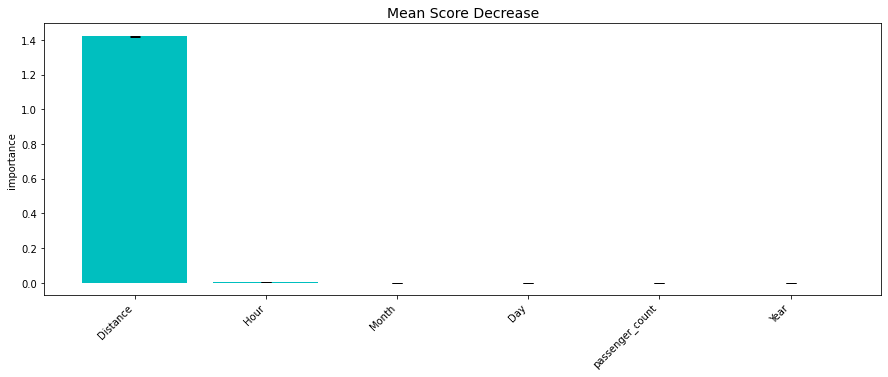

In [14]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

# Evaluation

In [15]:
from jcopml.plot import plot_residual

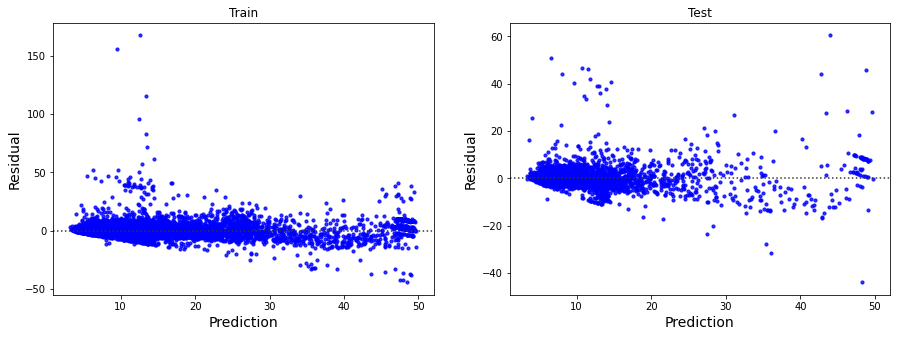

In [16]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Masih saja ada unbalance, mari kita cek datanya

In [ ]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values('error', ascending=False).head(10)

In [19]:
df = df[(df.Distance > 0) & (df.fare_amount > 0)]

# Correlation Matrix

Pearson 
- Linear Relationship
- Syarat: berdistribusi normal

Spearman
- Rank relationship
- syarat: subjek yang berbeda
- contoh: Nilai yang diberikan oleh Guru A vs Guru B
- contoh: Harga saham A vs Harga saham B

Kendall
- Rank relationship
- syarat: subjek yang sama
- contoh: korelasi nilai quiz vs nilai ujian untuk murid A

In [20]:
from jcopml.plot import plot_correlation_matrix

In [24]:
df.head()

,fare_amount,passenger_count,Year,Month,Day,Hour,Distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [25]:
plot_correlation_matrix(df, 'fare_amount', numeric_col=['passenger_count','Year','Distance'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…